In [8]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from seabird.cnv import fCNV

# Cartopy for producing maps
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

In [30]:
# read each seabird cast from your directory
data_dir = 'data_cruise2'

cast6 = fCNV(data_dir+'/station6_loop_filter_teos10_bin.cnv')
cast7 = fCNV(data_dir+'/station7_loop_filter_teos10_bin.cnv')
cast8 = fCNV(data_dir+'/station8_loop_filter_teos10_bin.cnv')
cast9 = fCNV(data_dir+'/slope_loop_filter_teos10_bin.cnv')

In [10]:
# covert the data one station at a time to xarray
# ideally would make this more generic - but for now, it works!

# Station 9

In [11]:
# get data from cnv file
depth    = cast9['DEPTH']
temperature = cast9['TEMP']
salinity    = cast9['PSAL']

# put the data in a dictionary
datadic = { 'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity}
#datadic

In [12]:
# convert the dictionary to a pandas dataframe
cast9df=pd.DataFrame.from_dict(datadic)
#cast9df

In [13]:
# convert pandas to xarray
cast9xr = cast9df.set_index('depth').to_xarray()
#cast9xr

In [14]:
# add latitude and longitude coordinates
cast9xr = cast9xr.assign_coords({'latitude': xr.DataArray(cast9.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast9.attributes['LONGITUDE']),
                                 'station':9
                                  }
                                  )   
#cast9xr

# Station 8

In [19]:
# get data from cnv file
depth    = cast8['DEPTH']
temperature = cast8['TEMP']
salinity    = cast8['PSAL']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity}

# convert the dictionary to a pandas dataframe
cast8df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast8xr = cast8df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast8xr = cast7xr.assign_coords({'latitude': xr.DataArray(cast8.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast8.attributes['LONGITUDE']),
                                 'station':8
                                  }
                                  )   
#cast8xr

# Station 7

In [20]:
# get data from cnv file
depth    = cast7['DEPTH']
temperature = cast7['TEMP']
salinity    = cast7['PSAL']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity}

# convert the dictionary to a pandas dataframe
cast7df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast7xr = cast7df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast7xr = cast7xr.assign_coords({'latitude': xr.DataArray(cast7.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast7.attributes['LONGITUDE']),
                                 'station':7
                                  }
                                  )   
#cast7xr

# Station 6?

In [31]:
# get data from cnv file
depth    = cast6['DEPTH']
temperature = cast6['TEMP']
salinity    = cast6['PSAL']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity}

# convert the dictionary to a pandas dataframe
cast6df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast6xr = cast6df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast6xr = cast6xr.assign_coords({'latitude': xr.DataArray(cast6.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast6.attributes['LONGITUDE']),
                                 'station':6
                                  }
                                  )   
#cast7xr

# Combine casts

In [32]:
# combine all the casts into one xarray dataset
ctdsection = xr.concat([cast6xr, cast7xr,cast8xr,cast9xr],"cast")
#ctdsection

In [33]:
# calculate distance
d = gsw.distance(ctdsection.longitude.values,ctdsection.latitude.values)/1e3 # km
dist = np.cumsum(np.hstack([0,d]))

# add distance coordinate
ctdsection = ctdsection.assign_coords({'distance' : xr.DataArray(dist, coords=[ctdsection.station], dims='cast')})

ctdsection.distance.attrs['units'] = 'km'
#ctdsection

In [34]:
# add units for others
ctdsection.depth.attrs['units'] = 'm'
ctdsection.temperature.attrs['units'] = 'degree C'
ctdsection.salinity.attrs['units'] = 'psu'

# Add a map to decide which stations to include

C:\Users\kelly\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\kelly\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(-73.7, 41.74, 'CTD stations')

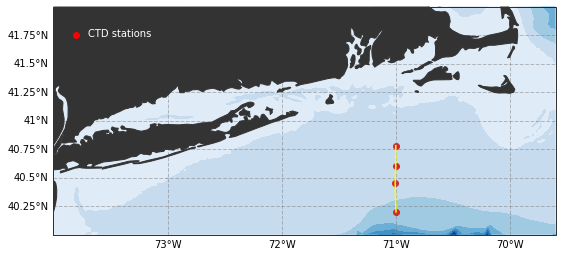

In [35]:
extent = [-74,-69.6,40,42]

# Download ETOPO1 topography for the domain(this may take a minute)
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bat = xr.open_dataset(url)
bat = bat.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))

projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
ax.set_extent(extent)

# Plot topography
bat['topo'].plot.contourf(
        ax=ax,levels=np.linspace(-500,100,10),add_colorbar=False,extend='neither',cmap='Blues_r',transform=projection)

_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face', facecolor='0.2'),
                                                zorder=3)

# plot ADCP track
plt.plot(ctdsection.longitude, ctdsection.latitude, color='yellow')

# plot CTD stations
ctdsection.plot.scatter('longitude', 'latitude', color='tab:red')#,transform=projection)

gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = gl.ylabels_right = False

plt.plot(-73.8, 41.75,'ro',transform=projection,zorder=5)
plt.text(-73.7,41.74,'CTD stations',color='w',transform=projection,zorder=5)

# Plot cross section!

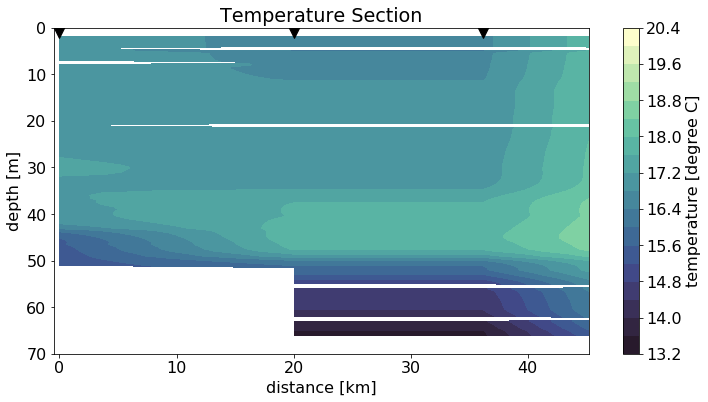

In [36]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.temperature.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Temperature Section")

plt.savefig('Figures/temperaturesection789.png')

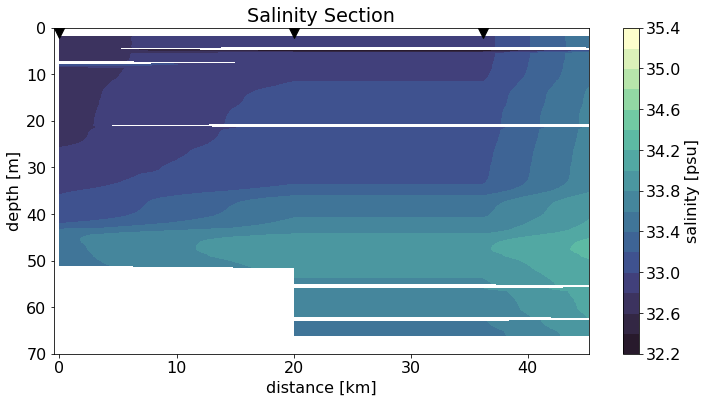

In [37]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.salinity.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Salinity Section")

plt.savefig('Figures/salinitysection789.png')